<a href="https://colab.research.google.com/github/dalisson/IntroducaoRedesNeurais/blob/master/Introducao_redes_neurais_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Artificiais

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Neste post implementaremos uma rede neural usando um dos melhores frameworks da indústria, PyTorch outros frameworks conhecidos incluem keras e tensorflow, embora esses frameworks tenham sido feitos para deep learning, o processo de treino é o mesmo para redes 'rasas'.

Vamos usar uma rede de regressão para aproximar a equação F(x) = 3x + 9, por ser um problema linear usaremos apenas uma camada, um neurônio (peso + bias).

Começando importando as bibliotecas

In [0]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

### Regressão

Primeiro vamos gerar dados de treinamento

In [0]:
X = torch.ones((100,2))
X[:,0].uniform_(-1.,1)
# a coluna de 1 vai nos ajudar a criar a variável y
X[:5], X.shape

(tensor([[-0.9356,  1.0000],
         [ 0.7017,  1.0000],
         [ 0.2389,  1.0000],
         [-0.9795,  1.0000],
         [ 0.9769,  1.0000]]), torch.Size([100, 2]))

In [0]:
a = torch.tensor((3.,9)); a

tensor([3., 9.])

In [0]:
#criando a variável dependente Y = 3x + 9
Y = X@a
Y[:10]

tensor([ 6.1933, 11.1052,  9.7168,  6.0616, 11.9307,  8.2285, 10.0373, 10.3736,
         7.5578, 10.8102])

In [0]:
#ruido aleatorio para nao ficar tão fácil
Y += torch.rand(100)

In [0]:
#agora que eu criei Y, vou jogar a coluna de 1 fora
#observe que eu quero manter a entrada como vetor coluna
X = X[:,0].unsqueeze(-1)  # mantem a entrada como um vetor coluna e joga forma a coluna de 1
X[:5], X.shape

(tensor([[-0.9356],
         [ 0.7017],
         [ 0.2389],
         [-0.9795],
         [ 0.9769]]), torch.Size([100, 1]))

Text(0.5, 0, 'x')

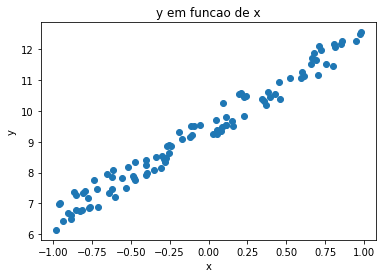

In [0]:
plt.scatter(X, Y)
plt.title('y em funcao de x');
plt.ylabel('y')
plt.xlabel('x')

Como podemos ver os nossos dados X estão armazenados em um tensor de rank 2 mas o que é um tensor?

#### Tensores

Tensor é uma daquelas coisas que parecem complicadas e na verdade é para as pessoas que estudam física, mas nos termos de redes neurais e deep learning tensor é apenas um array de tamanho regular, seu rank representa quantas dimensões ele tem.

In [0]:
#tensor de rank 2, uma matriz
rank2_tensor = torch.rand((3,2))
rank2_tensor

tensor([[0.9459, 0.5032],
        [0.4144, 0.3103],
        [0.4254, 0.9356]])

In [0]:
#tensor de rank 1, um array
rank1 = torch.rand(6)
rank1, rank1.shape

(tensor([0.6191, 0.9969, 0.6944, 0.8634, 0.4491, 0.9064]), torch.Size([6]))

O rank de um tensor de um tensor representa quanta informação precisamos para indexar um de seus itens em particular.

In [0]:
# nosso X é uma matriz uma coluna só, mas precisamos de dois numeros para indexar um elemento,
# logo, é um tensor de rank 2
X[:3], 'primeiro elemento de x: %s' % X[0][0]

(tensor([[-0.9356],
         [ 0.7017],
         [ 0.2389]]), 'primeiro elemento de x: tensor(-0.9356)')

In [0]:
#tensor de rank 0 é só um escalar
rank0 = torch.tensor(42)
rank0, rank0.shape

(tensor(42), torch.Size([]))

!!! Observação importante, tensores são obrigatoriamente arrays de tamanho regular, isto é, se uma das linhas de um tensor de rank 2 possui 4 elementos, todas as outras linhas obrigatoriamente possuem 4 elementos, isso é importante ao trabalhar com imagens, veremos mais sobre isso em breve.

In [0]:
#Alerta de spoiler, em visão computacional quase sempre trabalhamos com tensor de rank 4
rank4 = torch.rand((32,3,128,128))
rank4.shape #Na primeira dimensão é o batch, na segunda os canais de cor (para o pytorch) e nas outras altura e largura

torch.Size([32, 3, 128, 128])

A célula a seguir falha em executar ao tentar criar um batch com imagens de tamanho diferentes, para consertá-la experimente substituir 256 por 128 na última dimensão da imagem 2.

In [0]:
#vamos tentar concatenar duas imagens de tamanhos diferentes e ver o que acontece
image1 = torch.rand((3,128,128))
print('dimensoes image1', image1.shape)
image2 = torch.rand((3,128, 256)) #imagem maior que a segunda
print('dimensoes image2', image2.shape)
#precisamos criar mais uma dimensao nessas imagens para concatenalas em um batch de tamanho 2, caso contrario apenas criariamos uma imagem de 6 camadas.
image1 = image1.unsqueeze(0) #cria um novo eixo na posicao zero
print('nova dimensao image1', image1.shape)
image2 = image2[None] #mesma coisa que o anterior
print('nova dimensao image2', image2.shape)

batch = torch.cat((image1, image2), dim=0)
print('dimensao do batch', batch.shape)

dimensoes image1 torch.Size([3, 128, 128])
dimensoes image2 torch.Size([3, 128, 256])
nova dimensao image1 torch.Size([1, 3, 128, 128])
nova dimensao image2 torch.Size([1, 3, 128, 256])


RuntimeError: ignored

#### Implementação do Treinamento

Ok, temos a variável de entrada e a variável dependente (o que queremos prever), precisamos dos outros itens para construir o loop de treinamento, precisamos de uma rede, de uma função de perda para dizer ao modelo o quão bem ele está indo(nosso erro), de um método para atualizar os pesos da rede em virtude do erro e de uma métrica para nos dizer o quão bem estamos nos saindo na tarefa.

Enumerando:

- Dados.
- Rede Neural.
- Função de perda, para dizer a rede quao bem ela está indo.
- Metodo de atualização dos pesos, o optimizador.
- Métrica para nos dizer quão bem estamos indo.
- Por fim vamos iterar sobre os dados, calculando a saída e usando a perda (loss) para optimizar o modelo.

Também vamos definir o learning_rate ou taxa de aprendizado, esse parâmetro geralmente é representado pela letra alpha, representa o quanto do erro propagaremos para os pesos, learning_rates muito altos podem colapsar a rede e em geral é necessário alterá-lo ao longo do treinamento, não nos preocuparemos com isso agora.

In [0]:
#learning_rate
lr = 1e-1

##### Implementação da Rede

Vamos definir nossa Rede Neural, em pytorch redes podem ser classes ou só funções

In [0]:
#vamos fazer a rede manualmente, a variável de entrada tem uma feature e usaremos 
# um neurônio apenas, logo a matriz de pesos da camada é 1x1, também usaremos um termo de bias
w = nn.Parameter(torch.tensor([-1.]), requires_grad=True)
bias = nn.Parameter(torch.tensor([1.]), requires_grad=True)
def rede_neural(x):
  '''
  A rede é só uma função
  '''
  return x@w + bias # o simbolo @ multiplica matrizes em pytorch a funcao de ativacao e F(x)= x

'pesos %s e bias %s' % (w.data, bias.data)

'pesos tensor([-1.]) e bias tensor([1.])'

Nossa função de ativação será F(x) = x, ou seja não vamos fazer nada com a saída, por ser um problema linear não devemos ter problema e facilita a derivada que no caso é igual a 1.

##### Função de Perda

A função de perda mais comum para regressão o MSE, minimum squared error.

In [0]:
#Para a funcao de perda usaremos o mse, erro quadrado mínimo, erro = (y - y_hat)**2
def mse(y, y_hat): return ((y-y_hat)**2).mean()

Agora o método de atualização de pesos, usaremos o método do gradiente descente, os principais métodos avançados descendem de alguma forma dele.

##### Optimizador, Gradiente Descendente

O método utiliza o vetor gradiente (lembrança das aulas de cálculo), para nossos propósitos basta saber que existe o vetor gradiente, cujas componentes são as derivadas da função em relação a todas as variáveis, o interessante desse vetor é que ele sempre aponta em relação à direção de maior variação da função, então, achamos o vetor gradiente em relação à função de perda e vamos ajustar os pesos rumo ao sentido contrário, o sentido onde a perda (o erro do modelo) varia negativamente em maior intensidade.

Para propagar o erro através de multiplas camadas e ativações utilizamos a regra da cadeia (dx/dw x dloss/dw)

<p><img alt="gradiente descendente" height="400px"width="600px"src="https://miro.medium.com/max/1000/0*ZppAJQdr9FnrnrGG.jpg" align="right" hspace="10px" vspace="10px"></p>
<p> - A função do learning rate é controlar quao grande são os passos que tomamos em direção ao mínino do erro, note que se o passo for muito grande passariamos do mínimo e da melhor solução.</p>
<p> - Note também que a medida que nos aproximamos do mínimo queremos dar passos mais curtos para conseguir justo no melhor ponto, por isso costumamos ajustar o lr ao longo do treinamento, não fazemos isso aqui porque é uma tarefa muito fácil.</p>

In [0]:
#Logico que no mundo real e nos problemas que nos intessam o espaço de otimização é bem mais complexo, em muitas situações
#não conseguimos chegar ao mínimo global

<p><img alt="gradiente descendente" height="400px"width="600px"src="https://miro.medium.com/max/699/1*mElyetzsTIJrNnKI8kTkCw.jpeg" align="right" hspace="10px" vspace="10px"></p>

No nosso caso usaremos o gradiente descendente estocástico SGD na sigla em inglês. Estocástico porque no Gradiente Descendente cálculamos o erro corrigimos o peso depois de uma passada completa por todas as amostras, na prática isso é incrivelmente demorado e inviável, então fazemos um compromisso, passamos um batch de amostras, ou seja uma determinada quantidade, dependendo de quanto o computador aguenta por vez (em geral 32 ou 64 em tarefas com imagens) calculamos o erro e propagamos a correção pela rede. Nessa tarefa em particular faremos o tamanho do batch igual a 1 algo que frequentemente chamado tarefa de aprendizagem online.

Em situações normais não vamos nos preocupar em calcular derivadas, o autograd do pytorch mantém o rastro de como as coisas são calculadas e calcula a derivada para nós, precisamos apenas ativar essas função através do parâmetro requires_grad = True, teriamos feito isso se nao fossemos fazer tudo manual, algumas células atrás. Todavia, vamos fazer manualmente as coisas e esquecer o autograd no primeiro exercício.

##### Métrica

Como métrica vamos simplesmente olhar para o erro também. Mas ressaltamos a diferença entre métrica e função de perda, a métrica serve para o data scientist avaliar seu trabalho a função de perda é usada para ajustar o modelo. Agora sim, para o loop de treinamento.

##### Loop de Treinamento

Vamos iterar sobre os dados e fazer o procecimento de treino:
<P>Algoritmo:</P>
- Calcular F(x) para x.
- Calcular o erro para saber quao distante estamos da solução
- Calcular as derivadas, para ter o gradiente.
- Usar o gradiente para atualizar os parâmetros da rede.
- Repetir até ter o melhor resultado que consigmos ou número de iterações for grande o bastante.

In [0]:
#vamos fazer duas epochs
#epoch é a passagem completa por todos os dados de treinamento
def treinar_rede():
  for epoch in range(2):
    t = 0
    for x, y in zip(X,Y):
      y_hat = rede_neural(x)
      loss = mse(y, y_hat)
      t += 1
      if t % 10 == 0: print('erro', loss.detach().numpy())
      loss.backward()
      #derivadas calculadas manualmente

      dedw = -2*x*(y-y_hat) #em relacao ao peso
      dedbias = (-2*(y-y_hat)) # em relacao ao bias

      #Vamos verificar se o gradiente calculado manualmente é igual ao calculado pelo pytorch
      #como eles sao iguais usaremos o pytorch de agora em diante
      if t %100 == 0:
        print('\nverificando gradiente')
        print('gradiente de w automatico', w.grad.detach().numpy(), '| nosso calculo', dedw.detach().numpy())
        print('gradiente de bias automatico',bias.grad.detach().numpy(), '| nosso calculo', dedbias.detach().numpy())
        print()
      #temos que zerar manualmente a acumulação dos gradientes do torch
      #apesar de nao os estarmos usando na tarefa
      w.grad.zero_()
      bias.grad.zero_()
      with torch.no_grad():
        #ajuste dos parâmetros
        w.sub_(lr * dedw)
        bias.sub_(lr * dedbias)

In [0]:
treinar_rede()

erro 4.2218504
erro 0.54494375
erro 0.3846642
erro 0.00024134724
erro 0.16172974
erro 0.10416516
erro 0.0034280885
erro 0.16370282
erro 0.18220119
erro 0.02923138

verificando gradiente
gradiente de w automatico [-0.2828179] | nosso calculo [-0.2828179]
gradiente de bias automatico [0.34194374] | nosso calculo [0.34194374]

erro 0.008597181
erro 0.000365528
erro 0.15431646
erro 0.00035897546
erro 0.21193752
erro 0.1283401
erro 0.0014960008
erro 0.1749794
erro 0.17564544
erro 0.028373273

verificando gradiente
gradiente de w automatico [-0.2786358] | nosso calculo [-0.2786358]
gradiente de bias automatico [0.33688736] | nosso calculo [0.33688736]



In [0]:
#parâmetros depois de ajustados, lembre-se que eles foram inicializados em -1 e +1
w, bias

(Parameter containing:
 tensor([3.0348], requires_grad=True), Parameter containing:
 tensor([9.3756], requires_grad=True))

<H3>O que implementamos é a famosa Adaline o perceptron cuja função de ativaçao é F(x) = x, o Madaline, primeira rede utilizada para resolver problema do mundo real (e ainda em serviço) nada mais é do que o Adaline multicamada.</H3>

<h4>Agora que implementamos as coisas na mão, podemos usar as camadas prontas do Pytorch, o que faremos no próximo post da série.</h4>

<h4>A seguir vamos implementar uma rede multicamada para classificação, mas antes vamos ver nosso treinamento em progresso.</h4>
<h4>A rede que implementaremos se chama MLP, multilayer perceptron em bom português, perceptron multicamada, a diferença para o Madaline é que usaremos uma função de ativação chamada ReLU, essa é a função de ativação mais utilizada.

##### Por fim, vamos refazer todo o treinamento, porém, dessa vez, observaremos o processo de convergência da rede. 

In [0]:
#Mesmo treinamento utilizando funções no torch
#note que agora estamos fazendo o Gradiente descendentes, passamos todos os dados pela rede e depois calculamos a perda e depois atualizamos os pesos
def treinamento():
      y_hat = rede_neural(X)
      loss = mse(Y, y_hat)
      loss.backward()
      with torch.no_grad():
        #ajuste dos parâmetros
        w.sub_(lr * w.grad)
        bias.sub_(lr * bias.grad)
        w.grad.zero_()
        bias.grad.zero_()

In [0]:
#animacao com matplotlib
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [0]:
#reiniciando os pesos
w = nn.Parameter(torch.tensor([-1.]),requires_grad=True)
bias = nn.Parameter(torch.tensor([1.]),requires_grad=True)

fig = plt.figure()
plt.scatter(X, Y, c='orange')
line, = plt.plot(X, rede_neural(X).detach().numpy())
plt.close()

def animate(i):
    treinamento()
    line.set_ydata(rede_neural(X).detach().numpy())
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

Podemos ver que nossos parâmetros se aproximam da função que originou os dados, lembrando que eles foram inicializados em 1 e -1 para o peso e bias respectivamente.

In [0]:
w, bias

(Parameter containing:
 tensor([3.0163], requires_grad=True), Parameter containing:
 tensor([9.4619], requires_grad=True))